# Exopanet Hunting in Deep Space



## Description

Data taken from [KeplerAI](https://github.com/winterdelta/KeplerAI) project.

The data describe the change in flux (light intensity) of several thousand stars. Each star has a binary label of 2 or 1. 2 indicated that that the star is confirmed to have at least one exoplanet in orbit; some observations are in fact multi-planet systems.

### Task

Build a model that detects star systems with at least one planet. Test it with the test set described below.

### Trainset

- 5087 rows or observations
- 3198 columns or features
- Column 1 is the label vector
- Columns 2 - 3198 are the flux values over time

**37 confirmed exoplanet-stars and 5050 non-exoplanet-stars**

### Testset

- 570 rows or observations
- 3198 columns or features
- Column 1 is the label vector
- Columns 2 - 3198 are the flux values over time

**5 confirmed exoplanet-stars and 565 non-exoplanet-stars**

### Acknowledgements

The data presented here are cleaned and are derived from observations made by the NASA Kepler space telescope. The Mission is ongoing - for instance data from Campaign 12 was released on 8th March 2017. Over 99% of this dataset originates from Campaign 3. 

*-- To boost the number of exoplanet-stars in the dataset, confirmed exoplanets from other campaigns were also included. --*

## Imports & Drive mount

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15, 6)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Loading data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/ml-college/time-series-analysis/data/exoplanets/exoTest.csv')
df

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,...,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,...,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,...,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,...,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,22.84,25.99,-667.55,...,-122.12,-32.01,-47.15,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,107.2

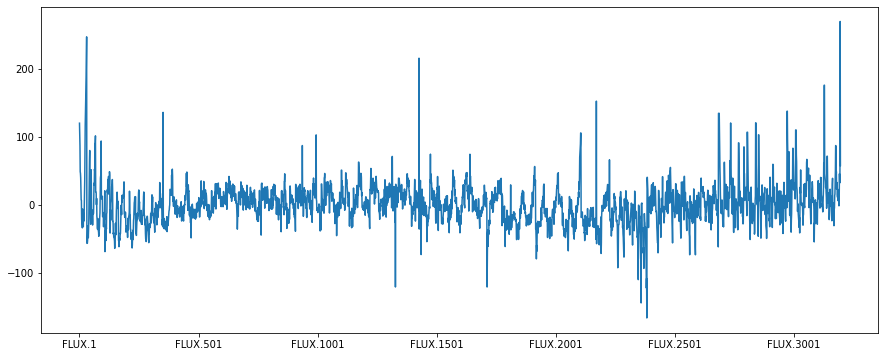

In [ ]:
df.loc[0,"FLUX.1":].plot()

In [ ]:
def read_exo_file(path):
    df = pd.read_csv(path)
    return df.loc[:,"FLUX.1":].values, df.loc[:,"LABEL"].values

In [ ]:
train_X, train_Y = read_exo_file('/content/drive/My Drive/ml-college/time-series-analysis/data/exoplanets/exoTrain.csv')
test_X, test_Y = read_exo_file('/content/drive/My Drive/ml-college/time-series-analysis/data/exoplanets/exoTest.csv')

## Data normalization

In [ ]:
sample = train_X[:200]

No normalization: 

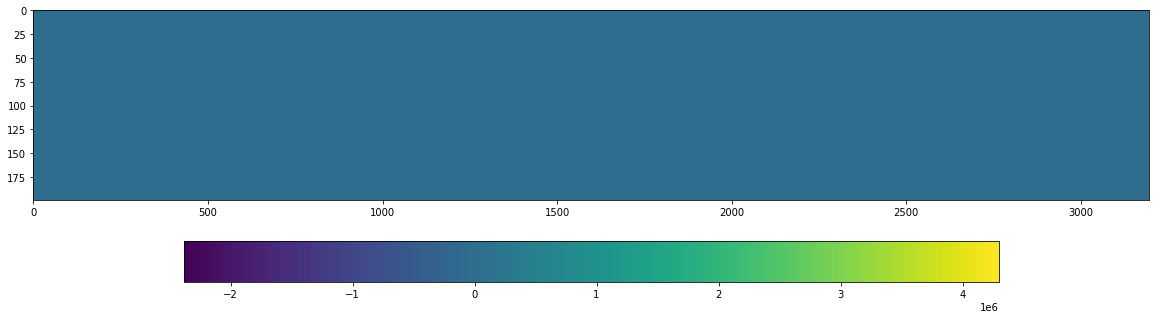

In [ ]:
min_val = np.min(train_X)
max_val = np.max(train_X)

fig = plt.figure(figsize=(20,5))
img = plt.imshow(sample, vmin=min_val, vmax=max_val, aspect='auto')
fig.colorbar(img, orientation='horizontal')
plt.show()

No normalization, start & end details:

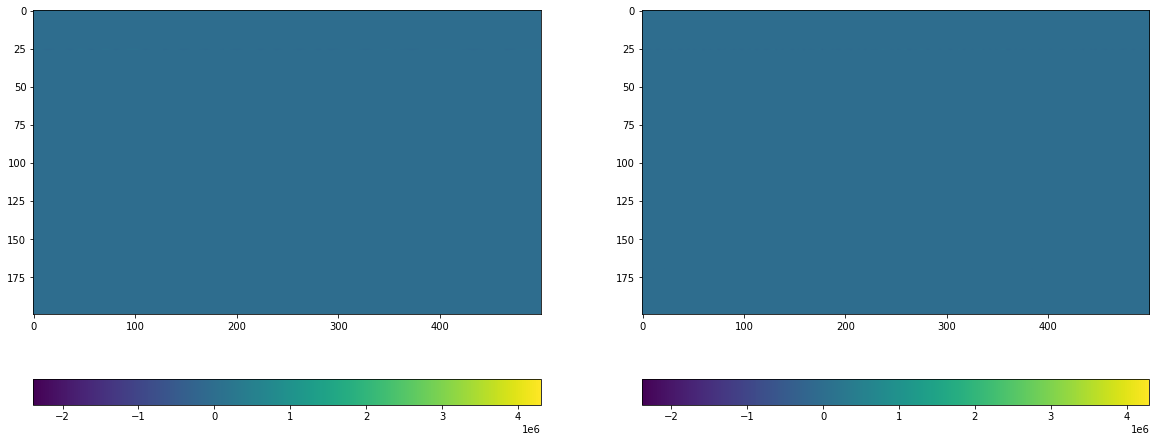

In [ ]:
def plot_sample(sample, max_val, min_val):
    fig, axes = plt.subplots(1,2, figsize=(20, 8))
    img1 = axes[0].imshow(sample[:,:500], vmin=min_val, vmax=max_val, aspect='auto')
    img2 = axes[1].imshow(sample[:,-500:], vmin=min_val, vmax=max_val, aspect='auto')
    fig.colorbar(img1, orientation='horizontal', ax=axes[0],)
    fig.colorbar(img2, orientation='horizontal', ax=axes[1])
    plt.show()

plot_sample(sample, max_val, min_val)

**Simple *substract minimum and divide by range* global normalization**

Is that correct? No visible change due to significant outliers in the data

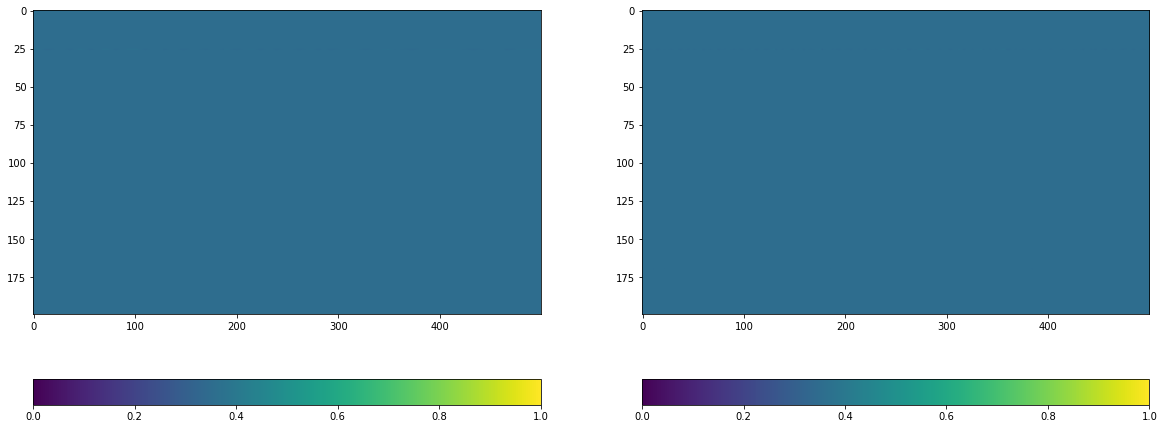

In [ ]:
normalized = ((sample - min_val) / (max_val - min_val))

plot_sample(normalized, 0, 1)

**Normalization using mean and standart deviation**

Better but it still seems to be affected by outliers (this time by "outlier stars")

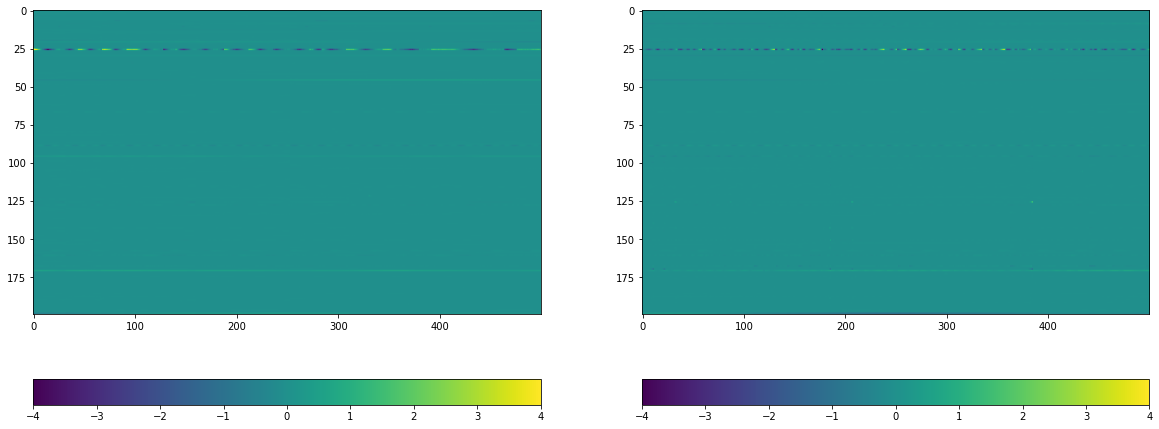

In [ ]:
mean = np.mean(train_X)
std = np.std(train_X)

normalized = ((sample - mean) / std)

plot_sample(normalized, -4, 4)

**Row-wise (per star) normalization with minimum and range**

... This looks way better

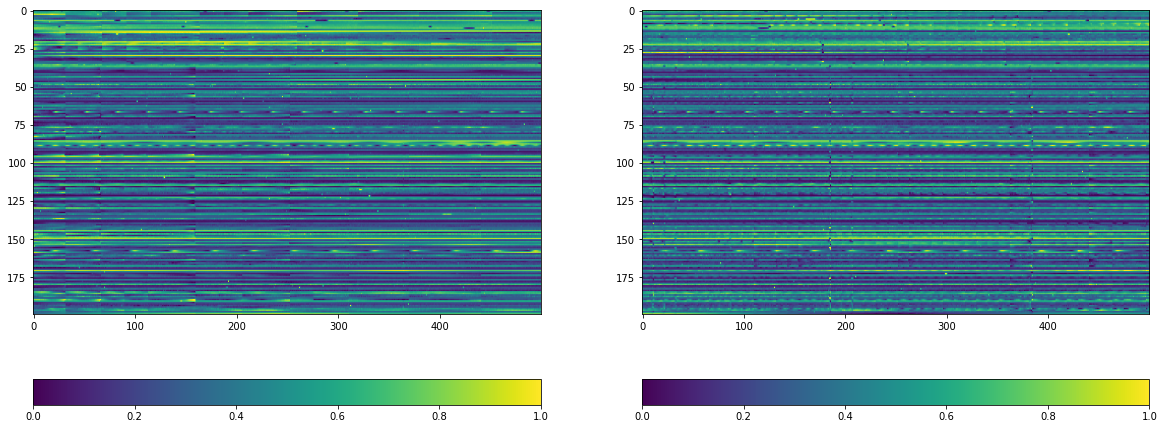

In [ ]:
min_vals = np.min(sample, axis=-1)
max_vals = np.max(sample, axis=-1)

row_normalized = ((sample.T - min_vals) / (max_vals - min_vals)).T

plot_sample(row_normalized, 0, 1)

**Row-wise normalization using mean and standard deviation**

This one seems best for our purposes

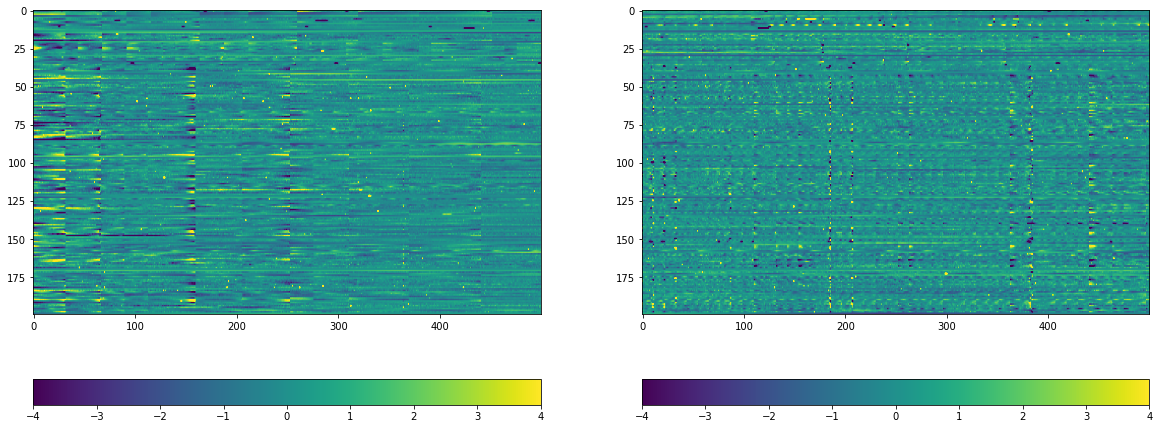

In [ ]:
mean_vals = np.mean(sample, axis=-1)
std_vals = np.std(sample, axis=-1)

row_normalized = ((sample.T - mean_vals) / std_vals).T

plot_sample(row_normalized, -4, 4)

## Training set construction

In [ ]:
from collections import Counter
Counter(train_Y)

Counter({1: 5050, 2: 37})

^ the dataset is **heavily disbalanced**

In [ ]:
def finalize_dataset(data_X, data_Y):

    mean_vals = np.mean(data_X, axis=-1)
    std_vals = np.std(data_X, axis=-1)
    
    norm_X = ((data_X.T - mean_vals) / std_vals).T
    norm_Y = data_Y - 1.0

    indices = list(range(len(data_X)))
    random.shuffle(indices)

    return norm_X[indices], norm_Y[indices]

In [ ]:
final_train_X, final_train_Y = finalize_dataset(train_X, train_Y)
print("Training input shape:", final_train_X.shape)
print("Training target shape:", final_train_Y.shape)

final_test_X, final_test_Y = finalize_dataset(test_X, test_Y)
print("Testing input shape:", final_test_X.shape)
print("Testing target shape:", final_test_Y.shape)

Training input shape: (5087, 3197)
Training target shape: (5087,)
Testing input shape: (570, 3197)
Testing target shape: (570,)


Finally, before we start with models, let's build an utility function for depicting test results and showing confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

def test_and_show(model):
    result = model.evaluate(final_test_X, final_test_Y)
    prediction = model.predict(final_test_X)

    true_pred = []
    false_pred = []

    for i, target in enumerate(final_test_Y):
        (true_pred if (target > 0) else false_pred).append(prediction[i])

    print(result)
    print(np.array(true_pred))

    plt.scatter(np.array(false_pred), np.full(len(false_pred), -10), color='b')
    plt.scatter(np.array(true_pred), np.full(len(true_pred), 20), color='r')
    plt.hist(np.array(false_pred), bins=100, alpha=0.3)
    plt.show()

def test_and_cfm(model, threshold):
    prediction = model.predict(final_test_X)
    return confusion_matrix(final_test_Y, [0 if x < threshold else 1 for x in prediction])

## Simple feed forward network

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense

inputs = Input(shape=(final_train_X.shape[-1],))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

ffn_model = Model(inputs, outputs)
ffn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
ffn_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3197)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                204672    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 207,425
Trainable params: 207,425
Non-trainable params: 0
________________________________________________

In [ ]:
ffn_model.fit(final_train_X, final_train_Y, epochs=20, validation_split=0.2)

Epoch 1/20
128/128 [==============================] - 1s 5ms/step - loss: 0.0646 - accuracy: 0.9926 - val_loss: 0.0439 - val_accuracy: 0.9931
Epoch 2/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0396 - accuracy: 0.9926 - val_loss: 0.0291 - val_accuracy: 0.9931
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 0.0257 - accuracy: 0.9926 - val_loss: 0.0425 - val_accuracy: 0.9931
Epoch 4/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.9926 - val_loss: 0.0436 - val_accuracy: 0.9931
Epoch 5/20
128/128 [==============================] - 1s 4ms/step - loss: 0.0168 - accuracy: 0.9941 - val_loss: 0.0489 - val_accuracy: 0.9921
Epoch 6/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 0.0686 - val_accuracy: 0.9912
Epoch 7/20
128/128 [==============================] - 0s 4ms/step - loss: 0.0107 - accuracy: 0.9978 - val_loss: 0.1285 - val_accuracy: 0.9921
Epoch 

We got to ~ 99% accuracy. But is it actually useful? Let's inspect the class ratio

In [ ]:
label_ratio = sum(final_test_Y) / len(final_test_Y)
label_ratio

0.008771929824561403

^ Such low class ratio means that a **model that always returns 0 will have accuracy of 99.132%**

The confusion matrix of the test set proves the model has ~ 0.0 recall i.e. not working at all.

18/18 [==============================] - 0s 2ms/step - loss: 0.3170 - accuracy: 0.9912
[0.3170456290245056, 0.9912280440330505]
[[1.4807953e-35]
 [2.2528718e-16]
 [3.7759187e-15]
 [2.0936586e-02]
 [1.8554364e-12]]


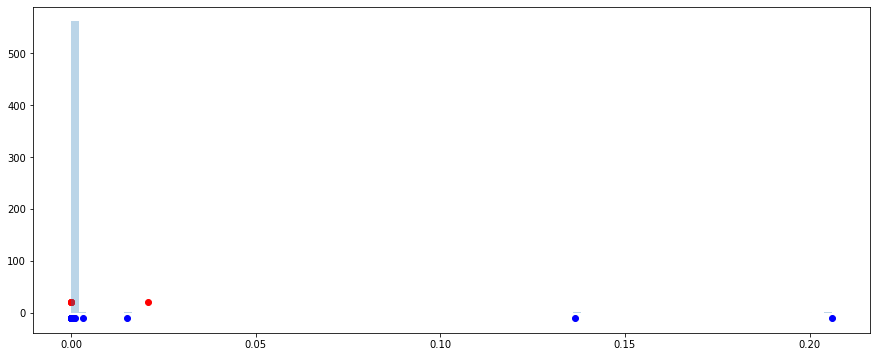

In [ ]:
test_and_show(ffn_model)

In [ ]:
test_and_cfm(ffn_model, 0.02)

array([[563,   2],
       [  4,   1]])

## LSTM

Can LSTM perform better? We can try to use bidirectional model as the process is reversible (planets can orbit in any direction i.e. playing the sequence back in time should not harm the results.

In [ ]:
from keras.layers import Bidirectional

inputs = Input(shape=(None, 1))
x = Bidirectional(LSTM(8))(inputs)
outputs = Dense(1, activation='sigmoid')(x)

lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer='sgd', loss='binary_crossentropy')
lstm_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit(final_train_X, final_train_Y, epochs=20, validation_split=0.2)

18/18 [==============================] - 1s 46ms/step - loss: 0.0508
0.05082504823803902
[[0.01294488]
 [0.0092994 ]
 [0.01032088]
 [0.00958084]
 [0.01004017]]


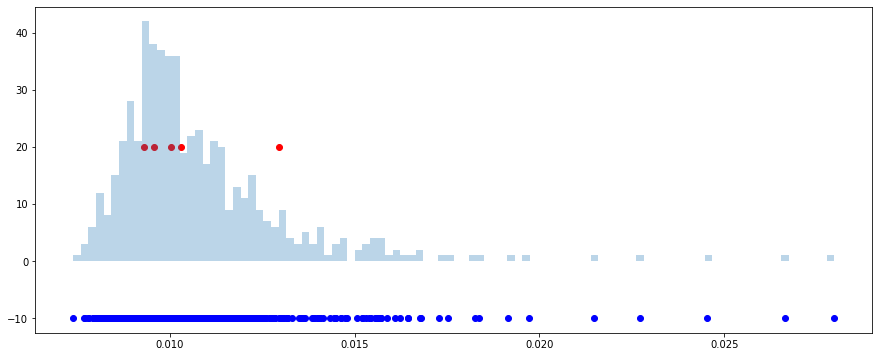

In [ ]:
test_and_show(lstm_model)

In [ ]:
test_and_cfm(lstm_model, 0.02)

array([[560,   5],
       [  5,   0]])

It's somehow better but we still have poor both recall and prection for real usage.

## Convolutional network

The data should have local patterns in flux changes (pulsars? planets?) so it might be useful to try convolution filters so let's try 1D convolutions.

It's also way faster than LSTMs and due to the nature of the task (classification and fixed sequence length) we can ignore the time dimension. Even if we do not have fixed sequence length, CNNs still can be used with the right golbal pooling layer.

In [ ]:
from keras.layers import Conv1D, MaxPool1D, Flatten, Dropout

def init_cnn_model():
    inputs = Input(shape=(final_train_X.shape[-1], 1))
    x = Conv1D(16, 3, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Conv1D(16, 3, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Conv1D(16, 3, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Conv1D(32, 3, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Conv1D(32, 3, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Conv1D(32, 3, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPool1D()(x)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    cnn_model = Model(inputs, outputs)
    cnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    return cnn_model

In [ ]:
cnn_model = init_cnn_model()
cnn_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3197, 1)]         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3195, 16)          64        
_________________________________________________________________
dropout_8 (Dropout)          (None, 3195, 16)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1597, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1595, 16)          784       
_________________________________________________________________
dropout_9 (Dropout)          (None, 1595, 16)          0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 797, 16)         

In [ ]:
cnn_model.fit(final_train_X, final_train_Y, validation_split=0.2, epochs=20)

Epoch 1/20
128/128 [==============================] - 1s 9ms/step - loss: 0.0559 - val_loss: 0.0452
Epoch 2/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0455 - val_loss: 0.0600
Epoch 3/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0431 - val_loss: 0.0805
Epoch 4/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0407 - val_loss: 0.0460
Epoch 5/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0412 - val_loss: 0.1237
Epoch 6/20
128/128 [==============================] - 1s 9ms/step - loss: 0.0408 - val_loss: 0.0494
Epoch 7/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0388 - val_loss: 0.1802
Epoch 8/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0380 - val_loss: 0.0424
Epoch 9/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0366 - val_loss: 0.0401
Epoch 10/20
128/128 [==============================] - 1s 8ms/step - loss: 0.0382 - val_loss: 0.0416

18/18 [==============================] - 0s 3ms/step - loss: 0.0421
0.042087312787771225
[[0.06537908]
 [0.00761786]
 [0.04780883]
 [0.00034116]
 [0.01254727]]


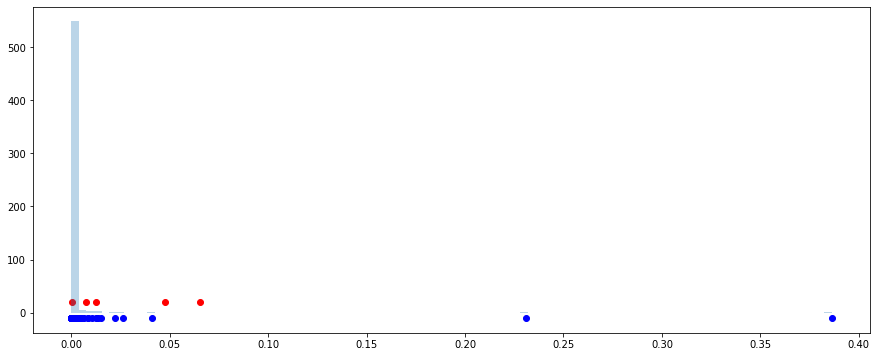

In [ ]:
test_and_show(cnn_model)

In [ ]:
test_and_cfm(cnn_model, 0.05)

array([[555,  10],
       [  2,   3]])

^ The results are better but for high recall we would suffer with a lot of false positives.

**It seems that changing model architecture does not lead to the solution. Let's try to improve our training data**

## Data Augmentation

Due to heavily unbalanced dataset, positive samples are supressed during the training. We can put more weights on them but then there will be huge steps in the gradient descent that can harm the convergence. It would be better to oversample with positive samples and distribute the error propagation from positive sample over the whole dataset.

- we have 37 positive samples (stars with confirmed panets) organized right at the top of the source dataset.

In [ ]:
train_Y[:38]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])

In [ ]:
positive_samples = train_X[:37]

In [ ]:
def normalize_and_show(sample):
    mean_vals = np.mean(sample, axis=-1)
    std_vals = np.std(sample, axis=-1)

    row_normalized = ((sample.T - mean_vals) / std_vals).T
    plot_sample(row_normalized, -4, 4)

This is how positive samples look like:

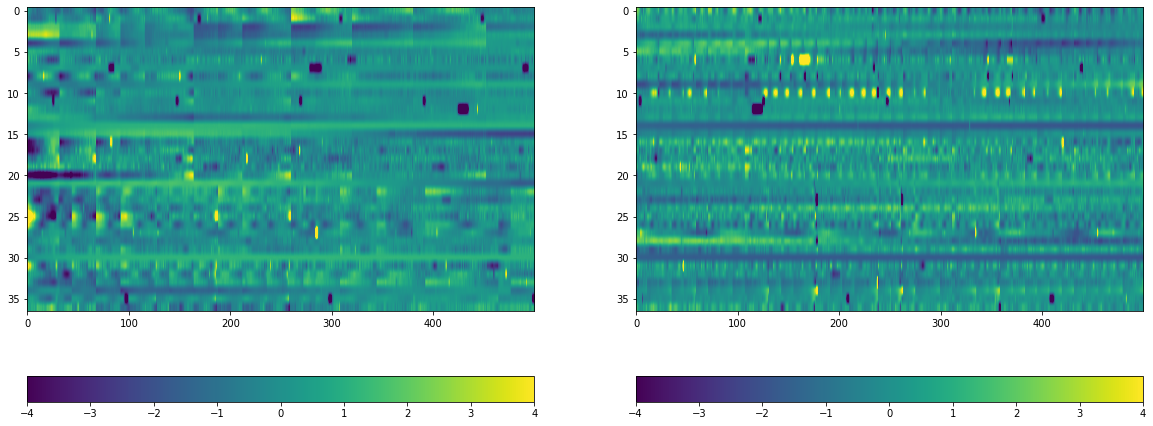

In [ ]:
normalize_and_show(positive_samples)

We can simply take these and put them in the training set several times (and we will do that) but there are other augmentation possible to reduce overfitting on oversampled positive samples:

- **Reversing in time** i.e. flipping along X-axis (*intuition: reversing is valid as the underlying physical process is probably reversible*)

*Notice the correct mirror effect in the right figure (and the left figure above)*

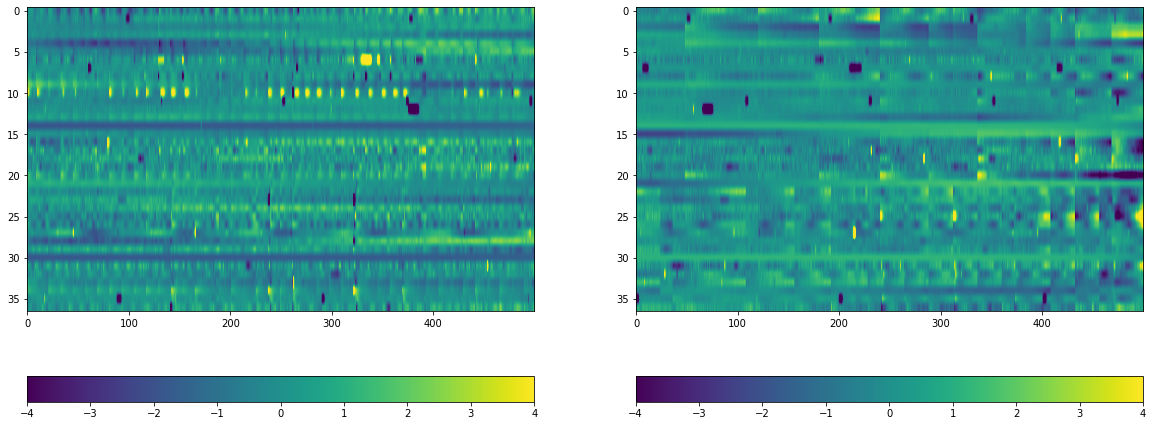

In [ ]:
flipped = np.flip(positive_samples, axis=-1)
normalize_and_show(flipped)

- **Circle shifting in time** (we don't know where are said planets in the data, this should help maintain higher level filters in CNN unbiased to the location)

*This is how samples shifted by 10% to the right look like:*

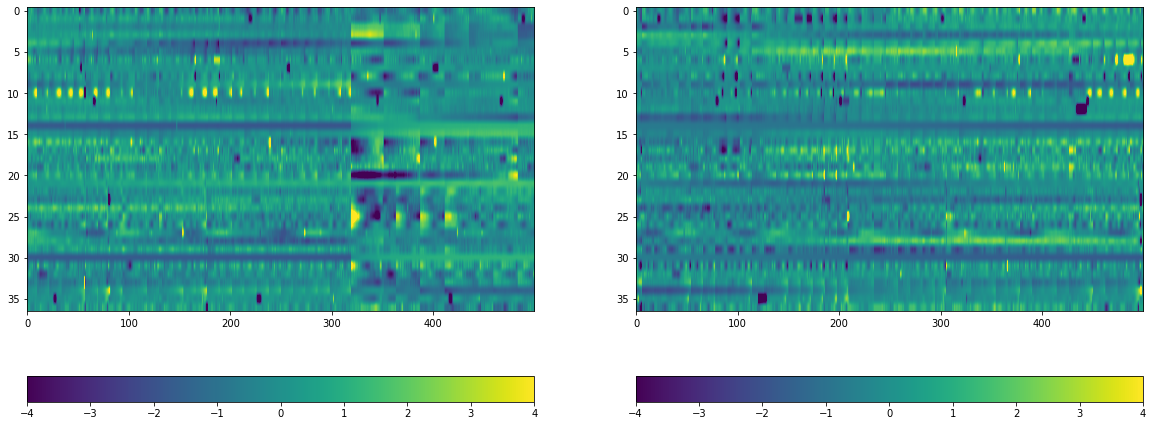

In [ ]:
shift = int(train_X.shape[-1] * 0.1)
shifted = np.roll(positive_samples, shift, axis=-1)

normalize_and_show(shifted)

So, let's use these transforms and their combination to produce more positive samples:

In [ ]:
shifted = [np.roll(positive_samples, int(train_X.shape[-1] * i * 0.1), axis=-1) for i in range(10)]
flipped_shifted = [np.roll(np.flip(positive_samples, axis=-1), int(train_X.shape[-1] * i * 0.1), axis=-1) for i in range(10)]

We can add untransformed positive samples as well (I've added them twice)

In [ ]:
augment = np.vstack([positive_samples, positive_samples, flipped, flipped] + shifted + flipped_shifted)

augmented_train_X = np.vstack((augment, train_X))
augmented_train_Y = np.concatenate((np.full(len(augment), 2), train_Y))

augment.shape

(888, 3197)

^ **We increase the number of positive samples from 37 to 888 !**

Let's retrain CNN model with augmented data

In [ ]:
final_train_X, final_train_Y = finalize_dataset(augmented_train_X, augmented_train_Y)
print("Training input shape:", final_train_X.shape)
print("Training target shape:", final_train_Y.shape)


Training input shape: (5975, 3197)
Training target shape: (5975,)


In [ ]:
cnn_model = init_cnn_model()

In [ ]:
cnn_model.fit(final_train_X, final_train_Y, epochs=20)

Epoch 1/20
187/187 [==============================] - 2s 8ms/step - loss: 0.3344
Epoch 2/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2591
Epoch 3/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2196
Epoch 4/20
187/187 [==============================] - 1s 7ms/step - loss: 0.1691
Epoch 5/20
187/187 [==============================] - 1s 7ms/step - loss: 0.1370
Epoch 6/20
187/187 [==============================] - 1s 7ms/step - loss: 0.1113
Epoch 7/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0953
Epoch 8/20
187/187 [==============================] - 1s 6ms/step - loss: 0.0880
Epoch 9/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0748
Epoch 10/20
187/187 [==============================] - 1s 6ms/step - loss: 0.0625
Epoch 11/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0622
Epoch 12/20
187/187 [==============================] - 1s 8ms/step - loss: 0.0563
Epoch 13/20
187/187 [====

18/18 [==============================] - 0s 4ms/step - loss: 0.0274
0.027407031506299973
[[0.8155013 ]
 [0.99756646]
 [0.9999871 ]
 [1.        ]
 [0.97428066]]


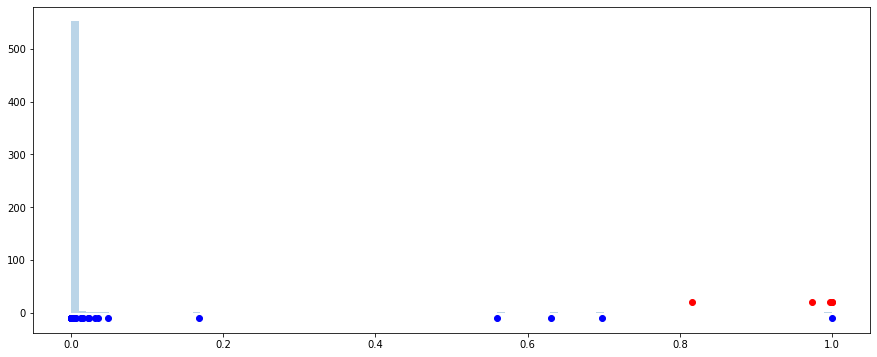

In [ ]:
test_and_show(cnn_model)

In [ ]:
test_and_cfm(cnn_model, 0.5)

array([[561,   4],
       [  0,   5]])

^ ...and it seems we got much better model! 

We frequently get to 100% recall on testing set and reasonable number of false positives.

In [ ]:
#Aux. task: test other architectures to see if CNN is still better than other models even with the augmented data.